In [110]:
from astropy.io import fits
from astropy.visualization import astropy_mpl_style 
from  astropy.utils.data import get_pkg_data_filename
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.style.use(astropy_mpl_style)
fits_file = fits.open(r'/home/andres/fotometria/NGC628/MAST_2023-11-08T0136/JWST/jw02107-o040_t018_nircam_clear-f335m/jw02107-o040_t018_nircam_clear-f335m_i2d.fits')

fits_file.info()

Filename: /home/andres/fotometria/NGC628/MAST_2023-11-08T0136/JWST/jw02107-o040_t018_nircam_clear-f335m/jw02107-o040_t018_nircam_clear-f335m_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     374   ()      
  1  SCI           1 ImageHDU        75   (4079, 2190)   float32   
  2  ERR           1 ImageHDU        10   (4079, 2190)   float32   
  3  CON           1 ImageHDU        10   (4079, 2190, 1)   int32   
  4  WHT           1 ImageHDU         9   (4079, 2190)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (4079, 2190)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (4079, 2190)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (4079, 2190)   float32   
  8  HDRTAB        1 BinTableHDU    828   8R x 409C   [23A, 5A, 3A, 48A, 7A, 13A, 6A, 7A, 6A, 7A, 10A, 4A, L, D, D, D, D, 32A, 50A, 70A, 11A, 2A, D, 47A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 13A, 2A, 26A, 20A, 27A, 10A, K, L, L

In [111]:
image_data = fits_file[1].data
fits_file.close()

In [112]:
from photutils import DAOStarFinder
from astropy.stats import mad_std 

# Measure the median absolute deviation and use it to estimate the noise
bkg_sigma = mad_std(image_data)

# Set up the star finder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*bkg_sigma)

# Find stars in the image
sources = daofind(image_data)

/tmp/ipykernel_77007/1614240913.py:1: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder


Text(0.5, 1.0, 'NGC 628')

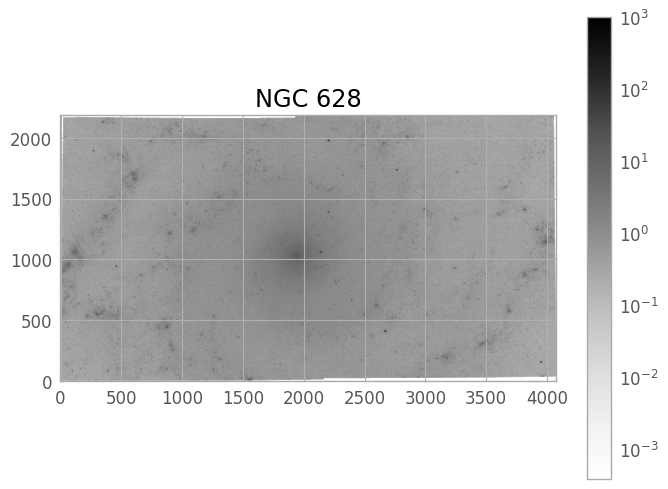

In [113]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(image_data,origin='lower', cmap= 'Greys', norm = LogNorm())
plt.colorbar()
plt.title("NGC 628")

Text(0.5, 1.0, 'NGC 628')

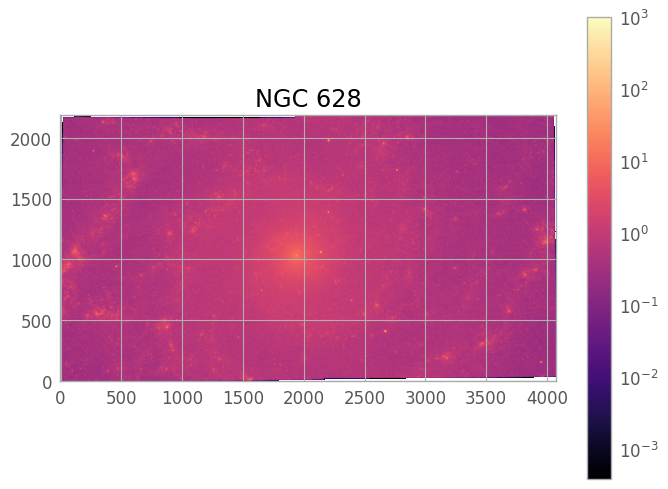

In [114]:
section1 = image_data[:8421, :14215]

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(section1, origin = 'lower', cmap= 'magma', norm = LogNorm())
plt.colorbar()
plt.title("NGC 628")

In [116]:
from photutils.datasets import make_100gaussians_image
npdata = make_100gaussians_image()
# Extract the data in an astropy table
from astropy.table import Table, Column
#my_table = Table(image[1].data)
#

In [118]:
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(npdata, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
npdata -= bkg.background  # subtract the background

In [119]:
threshold = 1.5 * bkg.background_rms

In [120]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(20, size=5)  # FWHM = 3.0
convolved_data = convolve(npdata, kernel)

In [121]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 86
labels: [ 1  2  3  4  5 ... 82 83 84 85 86]


Text(0.5, 1.0, 'Segmentation Image')

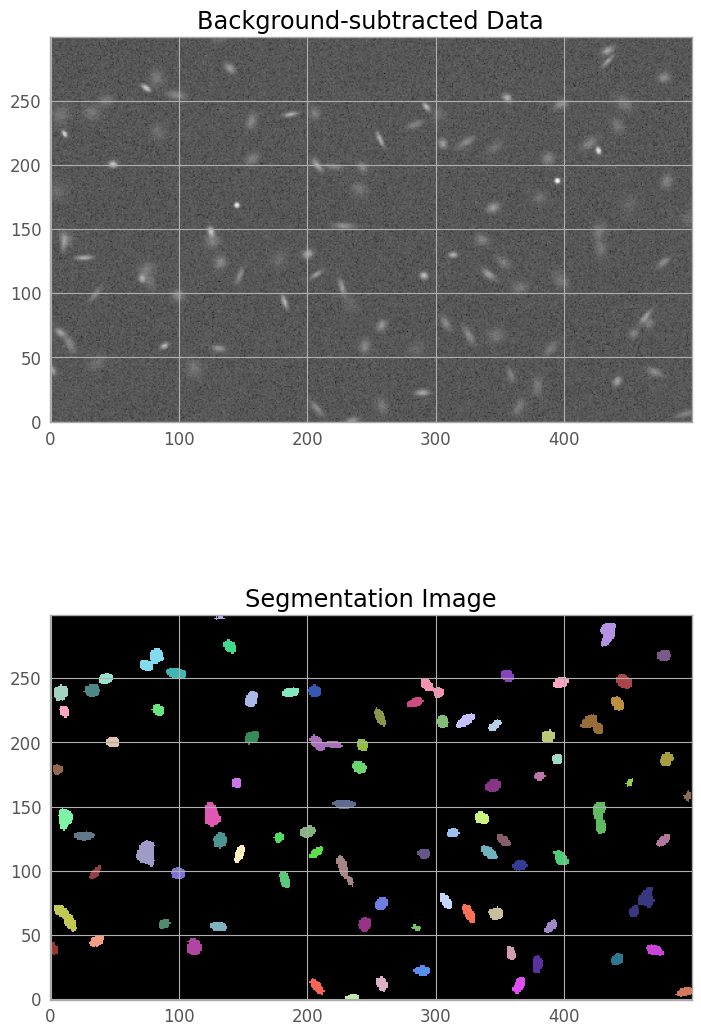

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(45, 12.5))
ax1.imshow(npdata, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

In [127]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(npdata, segment_map,
                               npixels=3.0, nlevels=32, contrast=0.001,
                               progress_bar=False) 

In [128]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(convolved_data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 116
labels: [  1   2   3   4   5 ... 112 113 114 115 116]


In [129]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    235.28      1.58 ...             nan    410.16          nan
    2    493.82      5.75 ...             nan    523.28          nan
    3    207.41      9.93 ...             nan    688.04          nan
    4    258.15     11.98 ...             nan    658.96          nan
    5    289.46     22.34 ...             nan    840.54          nan
    6    379.19     27.37 ...             nan    758.17          nan
    7    441.32     31.21 ...             nan    720.96          nan
    8    470.57     38.37 ...             nan    816.39          nan
    9      2.01     39.63 ...             nan    491.52          nan
   10    111.83     41.00 ...             nan    941.35          nan
  ...       ...       ... ...             ...       ...          ...
  107    292.94    244.98 ...     

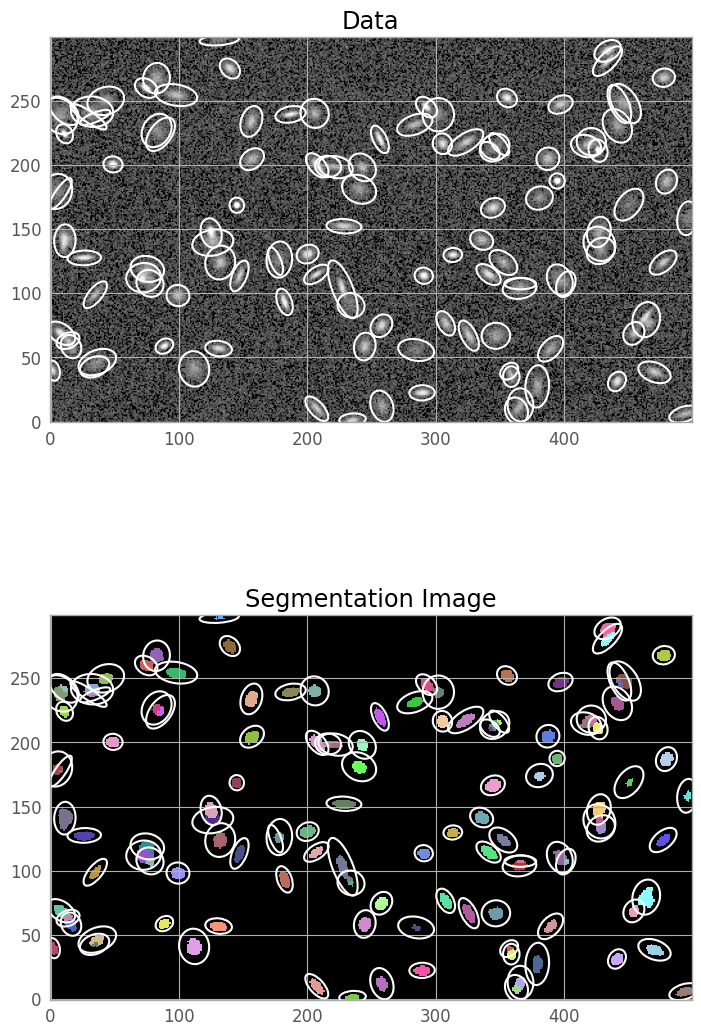

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(convolved_data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(npdata, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)